<h1>Project Title:</h1>
<h2>Air Quality Prediction Using Machine Learning</h2>

### Libraries Required:


In [ ]:
# Mount the drive to get the correct file
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### 1. Data Understanding

In [ ]:
# Load the dataset into a pandas DataFrame.
df = pd.read_excel('/content/drive/MyDrive/INTERNSHIP/AirQualityUCI.xlsx')

# Explore the data:
# View the first few rows using .head().
print(df.head(5))


# Check shape before any changes
print('\n Check Shape before cleaning.', df.shape)

# Check for missing values using .isnull().sum().
print(df.isnull().sum())

# Display data types and statistics using .info() and .describe().
print('\n Data Info')
df.info()
print('\n Data Describe', df.describe())


        Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)   C6H6(GT)  \
0 2004-03-10  18:00:00     2.6      1360.00       150  11.881723   
1 2004-03-10  19:00:00     2.0      1292.25       112   9.397165   
2 2004-03-10  20:00:00     2.2      1402.00        88   8.997817   
3 2004-03-10  21:00:00     2.2      1375.50        80   9.228796   
4 2004-03-10  22:00:00     1.6      1272.25        51   6.518224   

   PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
0        1045.50    166.0       1056.25    113.0       1692.00      1267.50   
1         954.75    103.0       1173.75     92.0       1558.75       972.25   
2         939.25    131.0       1140.00    114.0       1554.50      1074.00   
3         948.25    172.0       1092.00    122.0       1583.75      1203.25   
4         835.50    131.0       1205.00    116.0       1490.00      1110.00   

       T         RH        AH  
0  13.60  48.875001  0.757754  
1  13.30  47.700000  0.725487  
2  11.90  53.975000 

### 2. Data Preprocessing

In [ ]:
# Handle missing values:
# Replace invalid or missing values (-200) with NaN
df = df.replace(-200, np.nan)


# Use the column mean to fill missing values
numeric_col = df.select_dtypes(include = np.number).columns
df[numeric_col] = df[numeric_col].fillna(df[numeric_col].mean())


# Convert Date and Time columns into a single datetime column. Ensure it follows the YYYY-MM-DD HH:MM:SS format.
df['Time'] = pd.to_timedelta(df['Time'].astype(str))

# combine date and time column into the one single datetime column
df['datetime'] = df['Date'] + df['Time']


# Drop Original Columns Date and Time
df = df.drop(['Date', 'Time'], axis = 1)


# Check missing values
print(df.isnull().sum())


# Print new datetime column
print('\n New datetime column', df['datetime'].head(5))

# check shape
print('\n check shape after removing missing value', df.shape)

CO(GT)           0
PT08.S1(CO)      0
NMHC(GT)         0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
datetime         0
dtype: int64

 New datetime column 0   2004-03-10 18:00:00
1   2004-03-10 19:00:00
2   2004-03-10 20:00:00
3   2004-03-10 21:00:00
4   2004-03-10 22:00:00
Name: datetime, dtype: datetime64[ns]

 check shape after removing missing value (9357, 14)


### 3. Feature Engineering

In [ ]:
from sklearn.preprocessing import StandardScaler

# Retain important columns.
imp_cols = ['CO(GT)', 'NMHC(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)', 'PT08.S5(O3)',
                  'T', 'RH', 'AH', 'PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'datetime']

df = df[imp_cols]

# set index for the datetime
df.set_index('datetime', inplace = True)


# Scale the data using StandardScaler or MinMaxScaler.
numeric_col = df.select_dtypes(include = np.number).columns
scaler = StandardScaler()
df[numeric_col] = scaler.fit_transform(df[numeric_col])

# Display the First few rows to verify
print('\n First 5 Rows after feature engineering:')
print(df.head(5))

print('\n Data Types:')
print(df.dtypes)
print('\n Data Describe:')
print(df.describe())



 First 5 Rows after feature engineering:
                       CO(GT)  NMHC(GT)  C6H6(GT)   NOx(GT)   NO2(GT)  \
datetime                                                                
2004-03-10 18:00:00  0.339856 -1.077427  0.246331 -0.418187 -0.001720   
2004-03-10 19:00:00 -0.116071 -1.672415 -0.093922 -0.743922 -0.479984   
2004-03-10 20:00:00  0.035905 -2.048197 -0.148612 -0.599151  0.021055   
2004-03-10 21:00:00  0.035905 -2.173458 -0.116980 -0.387165  0.203251   
2004-03-10 22:00:00 -0.420023 -2.627528 -0.488185 -0.599151  0.066604   

                     PT08.S5(O3)         T        RH        AH  PT08.S1(CO)  \
datetime                                                                      
2004-03-10 18:00:00     0.626540 -0.544709 -0.021054 -0.676520     1.223265   
2004-03-10 19:00:00    -0.129371 -0.579359 -0.090280 -0.758039     0.904868   
2004-03-10 20:00:00     0.131134 -0.741061  0.279416 -0.695505     1.420648   
2004-03-10 21:00:00     0.462045 -0.845012  0.63438

### 4. Model Development

In [ ]:
from sklearn.model_selection import train_test_split
from prophet import Prophet


# Rename the datetime column to ds and the target column to y.
df_prophet = df.reset_index().rename(columns = {'datetime': 'ds', 'CO(GT)': 'y'})

# Split the data into training and testing sets using train_test_split
train_data, test_data = train_test_split(df_prophet, test_size=0.2, shuffle = False)

# Train the model on ds and y.
model = Prophet(yearly_seasonality = True, weekly_seasonality = True, daily_seasonality = True)
model.fit(train_data[['ds', 'y']])

# Predict future air quality levels
future = model.make_future_dataframe(periods = len(test_data))
forecast = model.predict(future)

# Display the forecast for the test Period
print('\n Forecast for test period')
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(len(test_data)))


# merge with actual values
forecast = forecast.merge(test_data[['ds', 'y']], on = 'ds', how = 'left')
print("\nForecast with actual values:")
print(forecast[['ds', 'y', 'yhat']].tail(len(test_data)))


DEBUG:cmdstanpy:input tempfile: /tmp/tmpz5xnj1fs/c_whg5fv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz5xnj1fs/ti04jn9n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16812', 'data', 'file=/tmp/tmpz5xnj1fs/c_whg5fv.json', 'init=/tmp/tmpz5xnj1fs/ti04jn9n.json', 'output', 'file=/tmp/tmpz5xnj1fs/prophet_model3a_pis_l/prophet_model-20250831063655.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:36:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:36:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



 Forecast for test period
                      ds      yhat  yhat_lower  yhat_upper
7485 2005-01-17 14:00:00  0.376406   -0.684681    1.386982
7486 2005-01-18 14:00:00  0.706511   -0.315106    1.657648
7487 2005-01-19 14:00:00  0.757271   -0.243483    1.800329
7488 2005-01-20 14:00:00  0.826044   -0.165250    1.796412
7489 2005-01-21 14:00:00  1.007358    0.007186    1.985492
...                  ...       ...         ...         ...
9352 2010-02-27 14:00:00 -5.292289   -6.286529   -4.216800
9353 2010-02-28 14:00:00 -5.600897   -6.542550   -4.530564
9354 2010-03-01 14:00:00 -5.321918   -6.371352   -4.328009
9355 2010-03-02 14:00:00 -5.109816   -6.063900   -4.204449
9356 2010-03-03 14:00:00 -5.176293   -6.209415   -4.178380

[1872 rows x 4 columns]

Forecast with actual values:
                      ds         y      yhat
7485 2005-01-17 14:00:00  0.719796  0.376406
7486 2005-01-18 14:00:00  2.315543  0.706511
7487 2005-01-19 14:00:00 -1.179903  0.757271
7488 2005-01-20 14:00:00  0.64

### 5. Model Evaluation


 Mean Absolute Error (MAE): 0.9121

 Root Mean Square Error (RMSE): 1.0942

 R-Square (R2): -1.0786


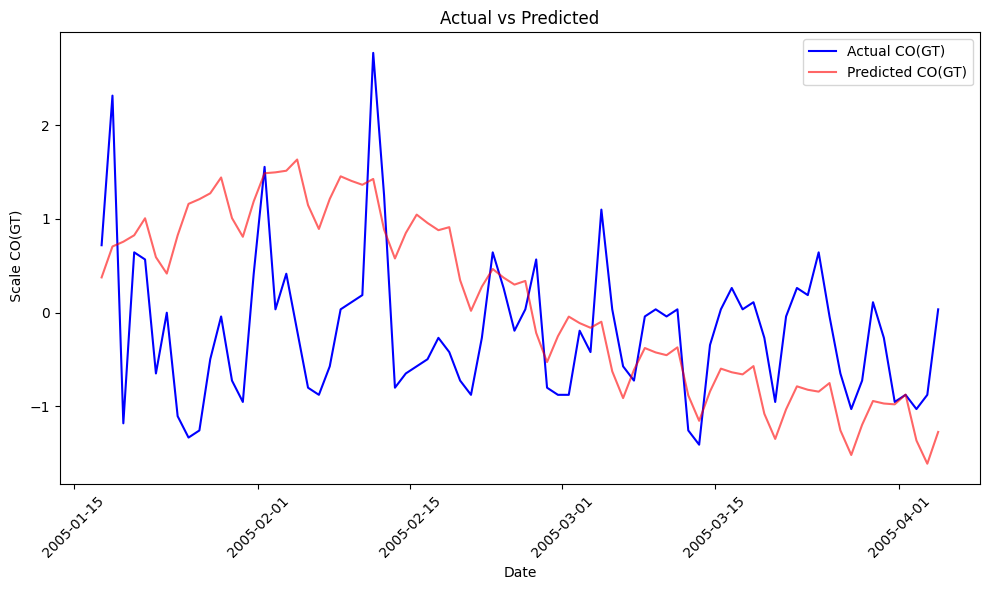

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Merge actual and predicted values for test
test_forecast = forecast[forecast['ds'].isin(test_data['ds'])].copy()
actual = test_forecast['y']
predicted = test_forecast['yhat']

# Use evaluation metrics such as:
# Mean Absolute Error (MAE), Root Mean Square Error (RMSE),  R-squared (R²)
mae = mean_absolute_error(actual, predicted)
rmse = np.sqrt(mean_squared_error(actual, predicted))
r2 = r2_score(actual, predicted)

# Print above 3 metrics
print(f'\n Mean Absolute Error (MAE): {mae:.4f}')
print(f'\n Root Mean Square Error (RMSE): {rmse:.4f}')
print(f'\n R-Square (R2): {r2:.4f}')


# Visualize actual vs. predicted
plt.figure(figsize = (10, 6))
plt.plot(test_forecast['ds'], actual, label = 'Actual CO(GT)', color = 'blue')
plt.plot(test_forecast['ds'], predicted, label = 'Predicted CO(GT)', color = 'red', alpha = 0.6)
plt.xlabel('Date')
plt.ylabel(' Scale CO(GT)')
plt.title('Actual vs Predicted')
plt.legend()
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()


### Explanation of results.

The Prophet model was evaluated using the following metrics:
- **Mean Absolute Error (MAE): 0.9121** - The average absolute difference between predicted and actual scaled CO(GT) values is 0.9121, indicating moderate prediction errors.
- **Root Mean Square Error (RMSE): 1.0942** - This higher value suggests larger errors are present, impacting overall accuracy.
- **R-squared (R²): -1.0786** - A negative R² indicates the model performs worse than a simple mean prediction, suggesting poor fit or potential overfitting.
